In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

import brutefit as bf

idx = pd.IndexSlice

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Model Choice

## Context

We have a variable $y$ which is dependant on several other variables, $x_0, \ldots, x_n$.
The form of this relationship and the contribution of each independent variable are unknown.

We need to identify which variables contribute most to $y$, and the 'best' model that predicts $y$ from x.

## Approach

In the most general case, a multivariate relationship may be approximated by a first order polynomial:

$$
f(x, y) = a_{10} x + a_{01} y + a_{00}
$$

or a second order polynomial:

$$
f(x, y) = a_{20} x^2 + a_{02} y^2 +a_{11} x y + a_{10} x + a_{01} y + a_{00}
$$

Polynomials including all combinations and permutations of input variables may be evaluated against the data to identify the 'best' model.

Furthermore, based on past work in biomineral and inorganic carbonates, we might also expect exponential relationships in the data, of the form:

$$
f(x) = a_{0} e^{a_1 x}
$$

These possibilities may be incorporated in our polynomial permutations in their linear form:

$$ \log{f(x)} = \log{a_0} + a_1 x $$

Where, for each combination of variables $x_n$, permutations are substituted with $\log{x_n}$ and evaluated against $\log{y}$.

Given this, we can fit a model for every possible combination and permutation of variables, and evaluate the goodness-of-fit resulting from the maximum likelihood parameters for all models.

### Special Cases

There are also a number of 'special 'case' models, which have been proposed in the literature. These will be evaluated alongside all polynomial forms of the model.

#### Exponential form
The original basis of the Mg/Ca palaeothermometer. Relates $Mg/Ca_f$ to temperature only. Exponential relationship has basis in thermodynamics of Mg substitution into calcite.
$$
\begin{align}
Mg/Ca_f &= p_0 e^{T p_T} \\
\log{(Mg/Ca_f)} &= \log{p_0} + T p_T
\end{align}
$$

#### Evans and Mueller (2012)
Modification of the pre-exponenetial term to account for seawater Mg/Ca. Empirically determined form.
$$
\begin{align}
Mg/Ca_{f} &= \frac{Mg/Ca_{SW}^{t=t}\ ^{p_M}}{Mg/Ca_{SW}^{t=0}\ ^{p_M}} p_0\ e^{T p_T} \\
Mg/Ca_{f} &= Mg/Ca_{SW}^{t=t}\ ^{p_M} Mg/Ca_{SW}^{t=0}\ ^{-p_M} p_0\ e^{T p_T} \\
\log{(Mg/Ca_{f})} &= p_M \log{(Mg/Ca_{SW}^{t=t})} - p_M \log{(Mg/Ca_{SW}^{t=0})} + \log{(p_0)} + T p_T \\
\log{(Mg/Ca_{f})} &= p_M (\log{(Mg/Ca_{SW}^{t=t})} - \log{(Mg/Ca_{SW}^{t=0})}) + \log{(p_0)} + T p_T
\end{align}
$$

#### Evans et al (2015)
An evolution of Evans and Mueller (2012) which provides an improved fit to culture data.
$$
\begin{align}
Mg/Ca_{f} &= \frac{p_{M2}\ Mg/Ca_{SW}^{t=t}\ ^2 + p_{M1}\ Mg/Ca_{SW}^{t=t}}{p_{M2}\ Mg/Ca_{SW}^{t=0}\ ^2 + p_{M1}\ Mg/Ca_{SW}^{t=0}} p_0\ e^{T p_T} \\
Mg/Ca_{f} &= (p_{M2}\ Mg/Ca_{SW}^{t=t}\ ^2 + p_{M1}\ Mg/Ca_{SW}^{t=t})(p_{M2}\ Mg/Ca_{SW}^{t=0}\ ^2 + p_{M1}\ Mg/Ca_{SW}^{t=0})^{-1} p_0\ e^{T p_T}
\end{align}
$$
The quadratic terms in the pre-exponent make it impossible to linearise this model. However, as the authors note, it produces substantively equivalent results to the formulation of Evans and Mueller (2012), so we consider evaluation of the previous model sufficient to test this family of equations.

#### Gray et al (2018)
An empirical fit to core-top data, with environmental variables interpolated from surface bottle data. A second form of the equation using $(pH - 8)$ in place of $[CO_3]$, but not included as it is equivalent to Gray & Evans (2019, below).
$$
\begin{align}
Mg/Ca_{f} &= e^{p_S(S - 35) + p_T T + p_{C} [CO_3] + p_0} \\
\log{(Mg/Ca_{f})} &= p_S(S - 35) + p_T T + p_{C} [CO_3] + p_0
\end{align}
$$


#### Gray & Evans (2019)
An empirical fit based on a review of available culture data.
$$
\begin{align}
Mg/Ca_{f} &= e^{p_S(S - 35) + p_T T + p_{pH} (pH - 8) + p_0} \\
\log{(Mg/Ca_{f})} &= p_S(S - 35) + p_T T + p_{pH} (pH - 8) + p_0
\end{align}
$$

## Model Evaluation

We consider the *best* model to be that which explains the most variance in the data with the least cofactors (or independent variables) - i.e. minimising over-fitting of the data, which reduces the model's predictive capabilities.

Metrics such as $R^2$ and $\chi^2$ to gauge the *goodness-of-fit* of a model, but neglect the number of cofactors included in the model so do not allow us to discern which model is *best*. 

*Information Criteria*, such as the Aikake Information Criterion (**AIC**) or Bayesian Information Criterion (**BIC**) take the goodness-of-fit, the number of covariates, and sample size (BIC only) into consideration to give a measure of the  *quality* of a model. These information criteria are useful, but are ultimately approximations of more difficult-to-calculate metrics from information theory ('information loss' and 'Bayes factor' in the cases of AIC and BIC, respectively).

In our evaluation, we employ a method to directly calculate the Bayes Factor of a model compared to a null-model ($y = c$) based on the model $R^2$, the number of covariates (= degress of freedom), and sample size [(Rouder & Morey, 2013)](https://doi.org/10.1080/00273171.2012.734737).

The Bayes Factor [(Kass & Raftery, 1995](http://www.doi.org/10.1080/01621459.1995.10476572) is defined as:
$$
B_{10} = \frac{p(\mathbf{D}|H_1)}{p(\mathbf{D}|H_0)}
$$

That is, the probablity ($p$) of the data ($\mathbf{D}$) given your hypothesis ($H_1$) relative to the probability of the data given a null hypothesis. In other words, if $B_{10} = 5$, the observed data are 5 times more probable if $H_1$ is correct, rather than $H_0$.

A convenient feature of Bayes Factors is that the relative probablity of the data given any two models may be calculated from the Bayes Factors comparing each of them to the same null model, i.e.:
$$
B_{21} = \frac{B_{20}}{B_{10}}
$$

Because the method of Rouder and Morey (2013) calculates the bayes factor of your model compared to the same null model ($y = c$), this means that the relative probabilities of all models may be calculated.

In evaluating Mg/Ca models, we use Rouder and Morey's (2013) method to calculate the $B_{N0}$ for all models, then compute the probability of all models relative to that with maximum $B_{N0}$. This allows us to directly compare and select our models, avoiding approximate measures such as AIC and BIC.

### Interpreting the Bayes Factor

As a general rule-of-thumb, Kass & Raftery (1995) suggest the following:

| $B_{10}$ | $\frac{1}{B_{10}}$  | Evidence against H0 |
|----------|---------------------|---------------------|
| 1-3.2    | 0.3125-1   | Not worth more than a bare mention |
| 3.2-10   | 0.1-0.3125 | Substantial |
| 10-100   | 0.01 - 0.1 | Strong |
| >100     | <0.01      | Decisive |

Note that these criteria are considerable more stringent than the 'p < 0.05' standard, which would correspond roughly to a Bayes Factor of ~20 (although direct comparisons like this are not really valid).

### Calculating Bayes Factor
In comparing our models we are fitting both $Mg/Ca_f$ and $\log(Mg/Ca_f)$, which makes it impossible to directly compare calculated goodness-of-fit statistics. To directly compare the models, we evaluate each in terms of the model $R^2$ in *linear* space - i.e. the prediction of a model optimised in log-space is transformed back into real-space before calculating $R^2$.

## Read Data

In [3]:
odat = pd.read_csv('Data/compiled_data.csv', header=[0,1], index_col=0)

In [4]:
dat = odat.copy()
# idx_exclude = dat.Measured.who.isin(['Allen', 'Lea', 'Hönisch'])
idx_exclude = np.zeros(dat.shape[0], dtype=bool)
idx_include = ~idx_exclude

# independent variables to include in the evaluation
xvars = [('Measured', 'Mg/Casw'),
         ('Measured', '[Ca]sw'),
         ('Measured', '[Mg]sw'),
         ('Measured', 'Temp'),
         ('csys_mid', 'DIC'),
         ('csys_mid', 'H')]

axvars = np.array(xvars)

# log variables for later
for x in xvars:
    dat.loc[:, ('ln', x[-1])] = np.log(dat.loc[:, x])

yvar = ('Measured', 'Mg/Caf')
yerr = ('Uncertainties', 'estimated_SE')

# sdat = dat
sdat = dat.loc[idx_include]  # subset containing selected studies

# isolate the independent (y) variables
X = sdat.loc[:, xvars].values

# isolate the dependent (y) variables
y = sdat.loc[:, yvar]
ye = sdat.loc[:, yerr]
w = 1 / ye

## Evaluate Candidate Models

In [5]:
brute = bf.Brute(X, y, w, transform=bf.transform.logTransform(), scale_data=False,
                 varnames=[x[1] for x in xvars])

In [6]:
modelfits = brute.evaluate_polynomials()

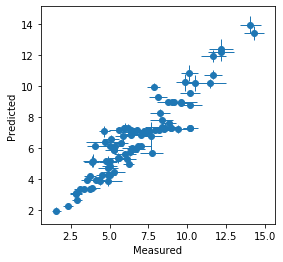

In [7]:
# check that the ensemble prediction performs well 
brute.plot_obs_vs_pred()

In [8]:
# view top 10 models
modelfits.head(10)

coefs                                                                    \
         C      X0^1       X1^1       X2^1       X3^1      X4^1         X5^1   
0 -4.09424  0.816647  0.0305517        NaN  0.0768739  0.358285          NaN   
1 -7.37005  0.818526  0.0306157        NaN    1.61174  0.356673          NaN   
2 -7.18755  0.625627        NaN        NaN    1.74819   0.36038          NaN   
3 -3.63972  0.624035        NaN        NaN  0.0835689  0.362109          NaN   
4 -3.98656  0.876803  0.0350383 -0.0625828  0.0768233  0.357533          NaN   
5 -7.29827  0.857354  0.0335127 -0.0403845    1.61075  0.356189          NaN   
6 -1.84157  0.800116  0.0228475        NaN  0.0760067  0.333723     0.105205   
7 -4.05407  0.809273  0.0266068        NaN  0.0772172  0.352192  4.48233e+06   
8 -5.08756  0.802042  0.0229395        NaN    1.59332  0.332216     0.104837   
9 -7.33983  0.811402  0.0267788        NaN    1.61695  0.350728  4.37168e+06   

      p_values                            ...      metrics transformed         \
             C         X0^1         X1^1  ... n_covariates          X0     X1   
0  1.70974e-14            0  1.83263e-06  ...            4        True  False   
1            0            0  1.63223e-06  ...            4        True  False   
2  2.22045e-16            0          NaN  ...            3        True  False   
3  1.09182e-11            0          NaN  ...            3        True  False   
4  1.80554e-10  6.73457e-06    0.0181746  ...            5        True  False   
5  4.44089e-16  9.59542e-06    0.0232471  ...            5        True  False   
6    0.0249179            0  0.000238588  ...            5        True  False   
7  3.26406e-14            0  2.96131e-05  ...            5        True  False   
8  6.17958e-07            0  0.000218025  ...            5        True  False   
9            0            0  2.55704e-05  ...            5        True  False   

                                metrics           \
      X2     X3    X4     X5     BF_max        K   
0  False  False  True  False          1        1   
1  False   True  True  False   0.961186  1.04038   
2  False   True  True  False    0.40555  2.46579   
3  False  False  True  False   0.168256  5.94334   
4   True  False  True  False   0.116175  8.60773   
5   True   True  True  False   0.100369  9.96323   
6  False  False  True   True  0.0810767   12.334   
7  False  False  True  False  0.0621585  16.0879   
8  False   True  True   True  0.0510329  19.5952   
9  False   True  True  False  0.0457527  21.8566   

                                       
                     evidence_against  
0                          Best Model  
1  Not worth more than a bare mention  
2  Not worth more than a bare mention  
3         Substantially less probably  
4         Substantially less probably  
5         Substantially less probably  
6              Strongly less probably  
7              Strongly less probably  
8              Strongly less probably  
9              Strongly less probably  

[10 rows x 26 columns]

### Interpreting this table
The table above contains a summary of all linear models that have been evaluated. It contains three key sections:
1. `coefs` contains the best-fit values of coefficients for each covariate in the linear model, where the column title denotes the variable and order of that term (i.e. `X1^2` is $X_1^2$, the $X_1$ term squared). If a value is `NaN`, it that coefficient has not been included in the model.
2. `transformed` contains either `True` or `False` for each variable, indicating whether the term has been transformed in the model evaluation. In this case, the transformation is a natrual logarithm, so wherever we see `True`, this variable has been log-transformed before fitting (e.g. if we see `True` for `X3`, the model is evaluating `log(X3)`.
3. `metrics` contains the metrics used to evaluate each model, as described above.

### Best Model

The form of the 'best' model remains unchanged when including *all* aggregate data, although there are now three similarly-probably candidate models.

$$
ln(Mg/Ca) = C + p_0 \log(Mg/Ca_{SW}) + p_1 Ca_{SW} + p_2 Temp + p_3 \log(DIC) \\
Mg/Ca = Mg/Ca_{SW}^{p_0}\ DIC^{p3}\ e^{p_1 Ca_{SW} + p_2 Temp + C} 
$$

## Special Cases

In [9]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

In [10]:
skey = {}
pn1 = PolynomialFeatures(degree=1)

Text(0.5, 1.0, 'R2: 0.14')

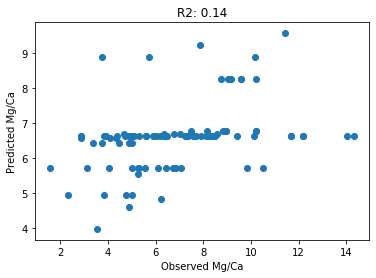

In [11]:
# Exponential Model
m = -1
skey[m] = 'Exponential Model'

txvars = [('Measured', 'Temp')]
# key = build_key(txvars, xvars, lnxvars)

X = pn1.fit_transform(sdat.loc[:, txvars])
Y = np.log(sdat.loc[:, yvar]).values
w = 1 / (sdat.loc[:, yerr] / sdat.loc[:, yvar])

mod = sm.WLS(Y, X, w)
fit = mod.fit()

# real-space observed and predicted
obs = sdat.loc[:, yvar].values
pred = np.exp(fit.predict())

R2 = bf.stats.calc_R2(obs, pred)

modelfits.loc[m, ('metrics', 'R2')] = R2
modelfits.loc[m, ('metrics', 'n_covariates')] = 1
modelfits.loc[m, ('metrics', 'BF0')] = bf.bayesfactor.BayesFactor0(X.shape[0], X.shape[1] - 1, R2)

plt.scatter(obs, pred)
plt.xlabel('Observed Mg/Ca')
plt.ylabel('Predicted Mg/Ca')
plt.title('R2: {:.2f}'.format(R2))

Text(0.5, 1.0, 'R2: 0.75')

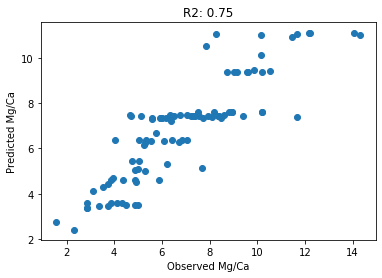

In [12]:
# Exponential Model - plus Mg/Ca
m = -2
skey[m] = 'Exponential Model'

txvars = [('ln', 'Mg/Casw'),
          ('Measured', 'Temp')]

X = pn1.fit_transform(sdat.loc[:, txvars])
Y = np.log(sdat.loc[:, yvar]).values
w = 1 / (sdat.loc[:, yerr] / sdat.loc[:, yvar])

mod = sm.WLS(Y, X, w)
fit = mod.fit()

# real-space observed and predicted
obs = sdat.loc[:, yvar].values
pred = np.exp(fit.predict())

R2 = bf.stats.calc_R2(obs, pred)

modelfits.loc[m, ('metrics', 'R2')] = R2
modelfits.loc[m, ('metrics', 'n_covariates')] = 2
modelfits.loc[m, ('metrics', 'BF0')] = bf.bayesfactor.BayesFactor0(X.shape[0], X.shape[1] - 1, R2)

plt.scatter(obs, pred)
plt.xlabel('Observed Mg/Ca')
plt.ylabel('Predicted Mg/Ca')
plt.title('R2: {:.2f}'.format(R2))

Text(0.5, 1.0, 'R2: 0.75')

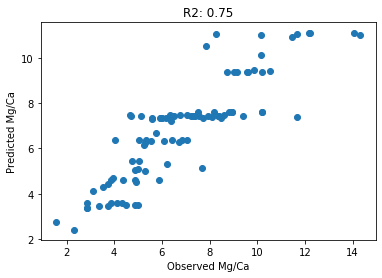

In [13]:
# Evans & Mueller (2012)
m = -3
skey[m] = 'Evans & Mueller (2012)'

X = np.vstack([
    np.ones(sdat.shape[0]),
    np.log(sdat.loc[:, ('Measured', 'Mg/Casw')]) / np.log(5.17),
    sdat.loc[:, ('Measured', 'Temp')]
]).T

txvars = [('Measured', 'Temp'), ('Measured', 'Mg/Casw')]

Y = np.log(sdat.loc[:, yvar]).values
w = 1 / (sdat.loc[:, yerr] / sdat.loc[:, yvar])

mod = sm.WLS(Y, X, w)
fit = mod.fit()

# real-space observed and predicted
obs = sdat.loc[:, yvar].values
pred = np.exp(fit.predict())

R2 = bf.stats.calc_R2(obs, pred)

modelfits.loc[m, ('metrics', 'R2')] = R2
modelfits.loc[m, ('metrics', 'n_covariates')] = 2
modelfits.loc[m, ('metrics', 'BF0')] = bf.bayesfactor.BayesFactor0(X.shape[0], X.shape[1] - 1, R2)

plt.scatter(obs, pred)
plt.xlabel('Observed Mg/Ca')
plt.ylabel('Predicted Mg/Ca')
plt.title('R2: {:.2f}'.format(R2))

Text(0.5, 1.0, 'R2: 0.15')

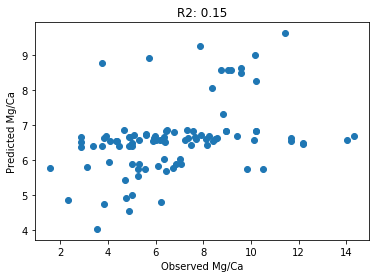

In [14]:
# Gray et al (2018) / Gray & Evans (2019) - pH
m = -4
skey[m] = 'Gray et al (2018) / Gray & Evans (2019) - pH'
X = np.vstack([
    np.ones(sdat.shape[0]),
    sdat.loc[:, ('Measured', 'Salinity')] - 35.,
    sdat.loc[:, ('Measured', 'Temp')],
    sdat.loc[:, ('csys_mid', 'pHtot')] - 8
]).T
txvars = [('Measured', 'Temp'), ('Measured', 'Salinity'), ('csys_mid', 'pHtot')]

Y = np.log(sdat.loc[:, yvar]).values
w = 1 / (sdat.loc[:, yerr] / sdat.loc[:, yvar])

mod = sm.WLS(Y, X, w)
fit = mod.fit()

# real-space observed and predicted
obs = sdat.loc[:, yvar].values
pred = np.exp(fit.predict())

R2 = bf.stats.calc_R2(obs, pred)

modelfits.loc[m, ('metrics', 'R2')] = R2
modelfits.loc[m, ('metrics', 'n_covariates')] = 3
modelfits.loc[m, ('metrics', 'BF0')] = bf.bayesfactor.BayesFactor0(X.shape[0], X.shape[1] - 1, R2)

plt.scatter(obs, pred)
plt.xlabel('Observed Mg/Ca')
plt.ylabel('Predicted Mg/Ca')
plt.title('R2: {:.2f}'.format(R2))

Text(0.5, 1.0, 'R2: 0.16')

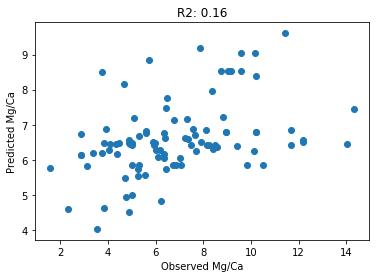

In [15]:
# Gray et al (2018) - CO3
m = -5
skey[m] = 'Gray et al (2018) - CO3'

X = np.vstack([
    np.ones(sdat.shape[0]),
    sdat.loc[:, ('Measured', 'Salinity')] - 35.,
    sdat.loc[:, ('Measured', 'Temp')],
    sdat.loc[:, ('csys_mid', 'CO3')]
]).T
txvars = [('Measured', 'Temp'), ('Measured', 'Salinity'), ('csys_mid', 'pHtot')]

Y = np.log(sdat.loc[:, yvar]).values
w = 1 / (sdat.loc[:, yerr] / sdat.loc[:, yvar])

mod = sm.WLS(Y, X, w)
fit = mod.fit()

# real-space observed and predicted
obs = sdat.loc[:, yvar].values
pred = np.exp(fit.predict())

R2 = bf.stats.calc_R2(obs, pred)

modelfits.loc[m, ('metrics', 'R2')] = R2
modelfits.loc[m, ('metrics', 'n_covariates')] = 3
modelfits.loc[m, ('metrics', 'BF0')] = bf.bayesfactor.BayesFactor0(X.shape[0], X.shape[1] - 1, R2)

plt.scatter(obs, pred)
plt.xlabel('Observed Mg/Ca')
plt.ylabel('Predicted Mg/Ca')
plt.title('R2: {:.2f}'.format(R2))

Text(0.5, 1.0, 'R2: 0.80')

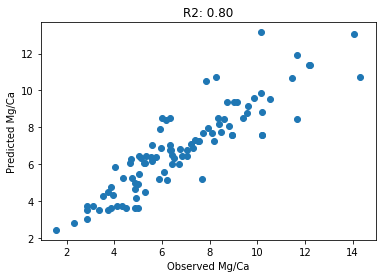

In [16]:
# Gray et al (2018) / Gray & Evans (2019) - pH and Mg/Casw
m = -6
skey[m] = 'Gray et al (2018) / Gray & Evans (2019) - pH and Mg/Casw'

X = np.vstack([
    np.ones(sdat.shape[0]),
    np.log(sdat.loc[:, ('Measured', 'Mg/Casw')]),
    sdat.loc[:, ('Measured', 'Salinity')] - 35.,
    sdat.loc[:, ('Measured', 'Temp')],
    sdat.loc[:, ('csys_mid', 'pHtot')] - 8.
]).T
txvars = [('Measured', 'Temp'), ('Measured', 'Salinity'), ('csys_mid', 'pHtot'), ('Measured', 'Mg/Casw')]

Y = np.log(sdat.loc[:, yvar]).values
w = 1 / (sdat.loc[:, yerr] / sdat.loc[:, yvar])

mod = sm.WLS(Y, X, w)
fit = mod.fit()

# real-space observed and predicted
obs = sdat.loc[:, yvar].values
pred = np.exp(fit.predict())

R2 = bf.stats.calc_R2(obs, pred)

modelfits.loc[m, ('metrics', 'R2')] = R2
modelfits.loc[m, ('metrics', 'n_covariates')] = 4
modelfits.loc[m, ('metrics', 'BF0')] = bf.bayesfactor.BayesFactor0(X.shape[0], X.shape[1] - 1, R2)

plt.scatter(obs, pred)
plt.xlabel('Observed Mg/Ca')
plt.ylabel('Predicted Mg/Ca')
plt.title('R2: {:.2f}'.format(R2))

Text(0.5, 1.0, 'R2: 0.76')

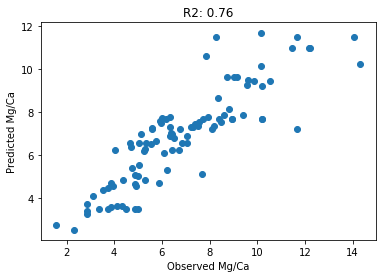

In [17]:
# Gray et al (2018) - CO3 and Mg/Casw
m = -7
skey[m] = 'Gray et al (2018) - CO3 and Mg/Casw'

X = np.vstack([
    np.ones(sdat.shape[0]),
    np.log(sdat.loc[:, ('Measured', 'Mg/Casw')]),
    sdat.loc[:, ('Measured', 'Salinity')] - 35.,
    sdat.loc[:, ('Measured', 'Temp')],
    sdat.loc[:, ('csys_mid', 'CO3')]
]).T
txvars = [('Measured', 'Temp'), ('Measured', 'Salinity'), ('csys_mid', 'pHtot'), ('Measured', 'Mg/Casw')]

Y = np.log(sdat.loc[:, yvar]).values
w = 1 / (sdat.loc[:, yerr] / sdat.loc[:, yvar])

mod = sm.WLS(Y, X, w)
fit = mod.fit()

# real-space observed and predicted
obs = sdat.loc[:, yvar].values
pred = np.exp(fit.predict())

R2 = bf.stats.calc_R2(obs, pred)

modelfits.loc[m, ('metrics', 'R2')] = R2
modelfits.loc[m, ('metrics', 'n_covariates')] = 4
modelfits.loc[m, ('metrics', 'BF0')] = bf.bayesfactor.BayesFactor0(X.shape[0], X.shape[1] - 1, R2)

plt.scatter(obs, pred)
plt.xlabel('Observed Mg/Ca')
plt.ylabel('Predicted Mg/Ca')
plt.title('R2: {:.2f}'.format(R2))

In [18]:
special = modelfits.index < 0
modelfits.loc[special, ('metrics', 'BF_max')] = modelfits.loc[special, ('metrics', 'BF0')] / modelfits.loc[~special, ('metrics', 'BF0')].max()
modelfits.loc[special, ('metrics', 'K')] = 1 / modelfits.loc[special, ('metrics', 'BF_max')]
modelfits.loc[modelfits.loc[:, ('metrics', 'K')] > 100, ('metrics', 'evidence_against')] = 'Decisively less probably'

In [19]:
modelfits.sort_values(('metrics', 'K'), inplace=True)

### Comparative metrics for special cases

In [20]:
modelfits.loc[(modelfits.metrics.K==1) | (modelfits.index < 0)]

coefs                                                         p_values  \
          C      X0^1       X1^1 X2^1       X3^1      X4^1 X5^1            C   
 0 -4.09424  0.816647  0.0305517  NaN  0.0768739  0.358285  NaN  1.70974e-14   
-6      NaN       NaN        NaN  NaN        NaN       NaN  NaN          NaN   
-3      NaN       NaN        NaN  NaN        NaN       NaN  NaN          NaN   
-2      NaN       NaN        NaN  NaN        NaN       NaN  NaN          NaN   
-7      NaN       NaN        NaN  NaN        NaN       NaN  NaN          NaN   
-1      NaN       NaN        NaN  NaN        NaN       NaN  NaN          NaN   
-5      NaN       NaN        NaN  NaN        NaN       NaN  NaN          NaN   
-4      NaN       NaN        NaN  NaN        NaN       NaN  NaN          NaN   

                      ...      metrics transformed                             \
   X0^1         X1^1  ... n_covariates          X0     X1     X2     X3    X4   
 0    0  1.83263e-06  ...            4        True  False  False  False  True   
-6  NaN          NaN  ...            4         NaN    NaN    NaN    NaN   NaN   
-3  NaN          NaN  ...            2         NaN    NaN    NaN    NaN   NaN   
-2  NaN          NaN  ...            2         NaN    NaN    NaN    NaN   NaN   
-7  NaN          NaN  ...            4         NaN    NaN    NaN    NaN   NaN   
-1  NaN          NaN  ...            1         NaN    NaN    NaN    NaN   NaN   
-5  NaN          NaN  ...            3         NaN    NaN    NaN    NaN   NaN   
-4  NaN          NaN  ...            3         NaN    NaN    NaN    NaN   NaN   

               metrics                                         
       X5       BF_max            K          evidence_against  
 0  False            1            1                Best Model  
-6    NaN  6.15857e-07  1.62375e+06  Decisively less probably  
-3    NaN  1.36353e-08  7.33388e+07  Decisively less probably  
-2    NaN  1.36353e-08  7.33388e+07  Decisively less probably  
-7    NaN  5.29412e-10  1.88889e+09  Decisively less probably  
-1    NaN  2.80541e-32  3.56454e+31  Decisively less probably  
-5    NaN  5.62281e-33  1.77847e+32  Decisively less probably  
-4    NaN  3.64021e-33  2.74709e+32  Decisively less probably  

[8 rows x 26 columns]